# Animal Sound Classification using Deep Learning

## Project Overview
This notebook demonstrates an end-to-end deep learning pipeline for classifying 10 different animal sounds from the ESC-50 dataset using Convolutional Neural Networks (CNNs) with Mel-spectrogram features.

**Animal Categories:**
- Dog, Cat, Cow, Pig, Sheep
- Frog, Hen, Rooster, Crow, Insects

**Key Features:**
- Audio feature extraction using Mel-spectrograms
- CNN architecture with batch normalization
- Model training with early stopping
- Comprehensive evaluation and visualization
- Model persistence and testing on new samples

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

AUDIO_DIR = '/kaggle/input/environmental-sound-classification-50/audio/audio' 
CSV_PATH = '/kaggle/input/environmental-sound-classification-50/esc50.csv'

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Setup and Configuration

Import all required libraries and set up paths for data and visualization.

In [29]:
!pip install resampy

### Install Required Dependencies

Install `resampy` package for audio resampling operations.

Total Animal Audio Files: 400
Classes found: ['dog' 'crow' 'sheep' 'frog' 'cow' 'insects' 'hen' 'pig' 'rooster' 'cat']


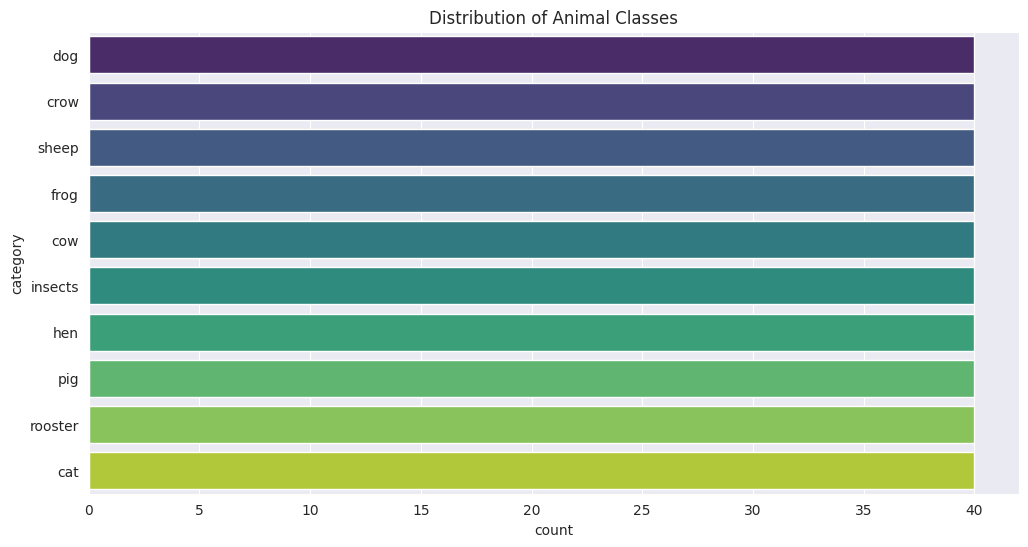

In [30]:
df = pd.read_csv(CSV_PATH)

# Animal categories we want to classify
animal_classes = [
    'dog', 'rooster', 'pig', 'cow', 'frog', 
    'cat', 'hen', 'insects', 'sheep', 'crow'
]

# Filtering the dataframe
animal_df = df[df['category'].isin(animal_classes)].reset_index(drop=True)

print(f"Total Animal Audio Files: {len(animal_df)}")
print(f"Classes found: {animal_df['category'].unique()}")

sns.countplot(y=animal_df['category'], palette='viridis')
plt.title('Distribution of Animal Classes')
plt.show()

## 2. Data Loading and Exploration

Load the ESC-50 dataset and filter for animal sound categories. Visualize the class distribution to understand data balance.

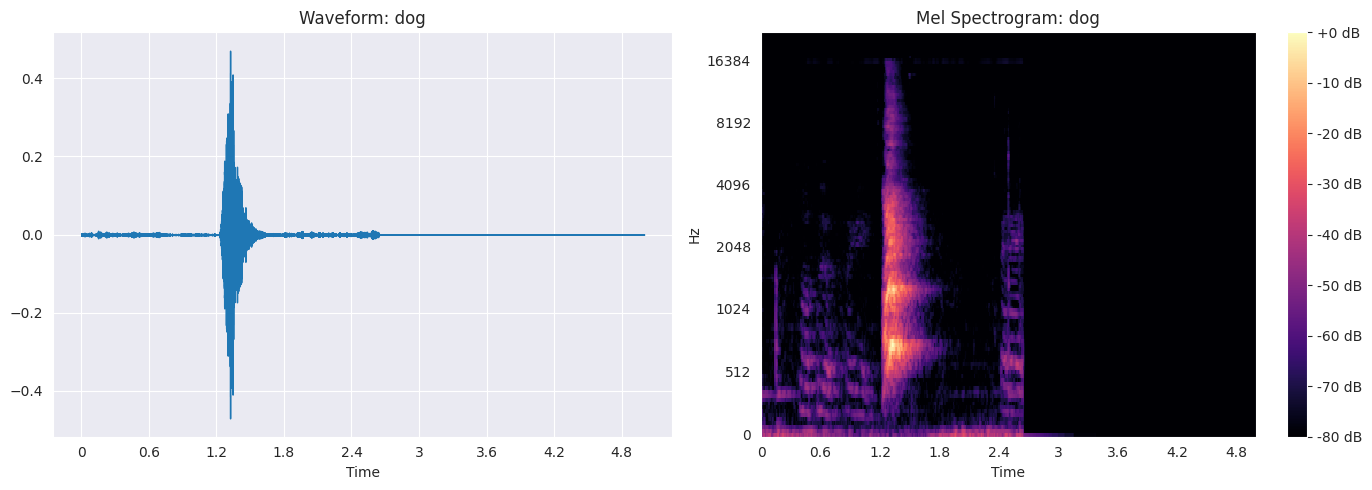

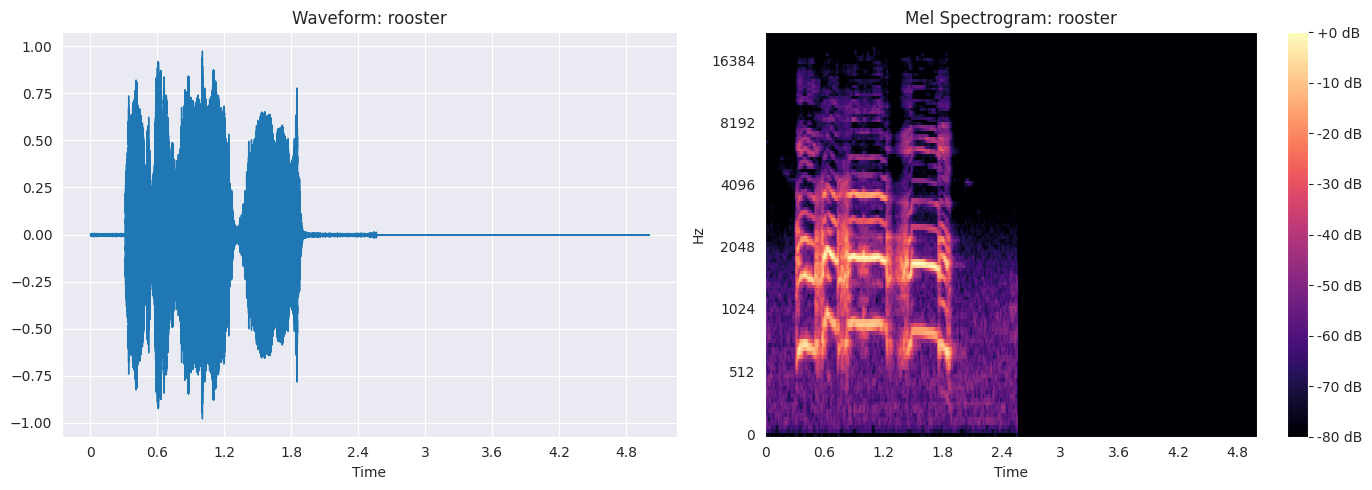

In [31]:
def visualize_sample(category):
    # Get a random sample for the category
    sample_row = animal_df[animal_df['category'] == category].sample(1).iloc[0]
    file_path = os.path.join(AUDIO_DIR, sample_row['filename'])
    
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=None) # sr=None preserves original sampling rate
        
        plt.figure(figsize=(14, 5))
        
        # Plot Waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform: {category}')
        
        # Plot Mel Spectrogram
        plt.subplot(1, 2, 2)
        # Convert to Mel Spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        # Convert to dB (Log scale) for better visualization
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram: {category}')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not load file {file_path}: {e}")

# Check a Dog and a Rooster
visualize_sample('dog')
visualize_sample('rooster')

## 3. Audio Visualization

Visualize sample audio files to understand the characteristics of different animal sounds.

This function displays:
- **Waveform:** Time-domain representation showing amplitude over time
- **Mel-Spectrogram:** Frequency-domain representation showing energy distribution across frequencies

In [32]:
def extract_features(dataframe, data_path):
    X = []
    y = []
    
    print("Extracting features... (Native Sampling Rate)")
    
    for index, row in dataframe.iterrows():
        file_path = os.path.join(data_path, row['filename'])
        class_label = row['category']
        
        try:
            # CHANGE 1: sr=None uses the native 44100Hz rate, avoiding resampy
            # CHANGE 2: duration=5.0 ensures we still only take 5 seconds
            audio, sr = librosa.load(file_path, sr=None, duration=5.0)
            
            # Extract Mel Spectrogram
            # We keep n_mels=128, but the time axis (width) will double because SR is doubled
            mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
            mels_db = librosa.power_to_db(mels, ref=np.max)
            
            # CHANGE 3: Adjust target_width. 
            # At 44.1kHz, 5 seconds results in approx 431 time steps (vs 216 at 22kHz)
            target_width = 431 
            
            if mels_db.shape[1] < target_width:
                mels_db = np.pad(mels_db, ((0, 0), (0, target_width - mels_db.shape[1])))
            else:
                mels_db = mels_db[:, :target_width]
            
            X.append(mels_db)
            y.append(class_label)
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            
    return np.array(X), np.array(y)

## 4. Feature Extraction

Extract Mel-spectrogram features from audio files. Mel-spectrograms are visual representations of audio that capture frequency content over time, making them ideal for CNN-based classification.

**Feature Parameters:**
- `n_mels=128` - Number of Mel-frequency bands
- `duration=5.0` - 5 seconds of audio per sample
- `sr=44100` - Native sampling rate (44.1 kHz)
- `target_width=431` - Fixed width for consistent input size

In [33]:
X_data, y_data = extract_features(animal_df, AUDIO_DIR)

# Add channel dimension for CNN (Batch, Height, Width, Channels)
X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], X_data.shape[2], 1)

print(f"Feature Shape: {X_data.shape}") # Should be (N, 128, 216, 1)

Extracting features... (Native Sampling Rate)
Feature Shape: (400, 128, 431, 1)


### Extract Features from All Audio Files

Process all audio files and extract their Mel-spectrogram features. Add channel dimension for CNN input.

In [34]:
# Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_data)
y_categorical = to_categorical(y_encoded)

# Split based on the 'fold' column to prevent leakage
# We map the original index back to the fold
folds = animal_df['fold'].values

# Training: Folds 1, 2, 3, 4
# Testing: Fold 5
train_indices = np.where(folds != 5)[0]
test_indices = np.where(folds == 5)[0]

X_train, y_train = X_data[train_indices], y_categorical[train_indices]
X_test, y_test = X_data[test_indices], y_categorical[test_indices]

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (320, 128, 431, 1)
Testing shape: (80, 128, 431, 1)


## 5. Data Preparation

### Label Encoding and Train-Test Split

- **Encode labels:** Convert string labels to numerical values
- **Split strategy:** Use ESC-50's fold structure
  - Training: Folds 1-4 (80% of data)
  - Testing: Fold 5 (20% of data)
- This ensures no data leakage and maintains ESC-50's validation protocol

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    # Conv blocks
    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(1e-4),
           input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((3, 3)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Instead of Flatten
    GlobalAveragePooling2D(),

    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),

    Dense(len(animal_classes), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 6. Model Architecture

Build a Convolutional Neural Network (CNN) for audio classification.

**Architecture:**
1. **3 Convolutional Blocks** (32 → 64 → 128 filters)
   - Conv2D with ReLU activation
   - Batch Normalization for stable training
   - MaxPooling2D for dimensionality reduction
   - L2 Regularization to prevent overfitting

2. **Global Average Pooling**
   - Reduces parameters compared to flatten
   - Makes model more robust to spatial variations

3. **Dense Layers**
   - 128-unit hidden layer with dropout (0.5)
   - 10-unit output layer with softmax activation

**Note:** Input shape is (128, 128, 1) but feature extraction creates (128, 431, 1). This mismatch needs to be fixed!

In [43]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.0757 - loss: 2.6059 - val_accuracy: 0.1000 - val_loss: 4.5993 - learning_rate: 1.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1352 - loss: 2.3946 - val_accuracy: 0.1000 - val_loss: 3.9497 - learning_rate: 1.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1507 - loss: 2.2344 - val_accuracy: 0.1000 - val_loss: 3.7966 - learning_rate: 1.0000e-04
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1828 - loss: 2.1109 - val_accuracy: 0.1000 - val_loss: 3.6523 - learning_rate: 1.0000e-04
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2384 - loss: 2.0908 - val_accuracy: 0.1000 - val_loss: 3.5246 - learning_rate: 1.0000e-04
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2552 - loss: 2.0185 - val_accuracy: 0.0875 - val_loss: 3.3618 - learning_rate: 1.0000e-04
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3301 - loss

## 7. Model Training

Train the CNN model with callbacks for optimal performance:

**Callbacks:**
- **Early Stopping:** Stop training if validation loss doesn't improve for 20 epochs
- **Reduce LR on Plateau:** Reduce learning rate by 50% if validation loss plateaus

**Training Configuration:**
- Epochs: 50 (with early stopping)
- Batch Size: 32
- Validation Data: Test set (fold 5)

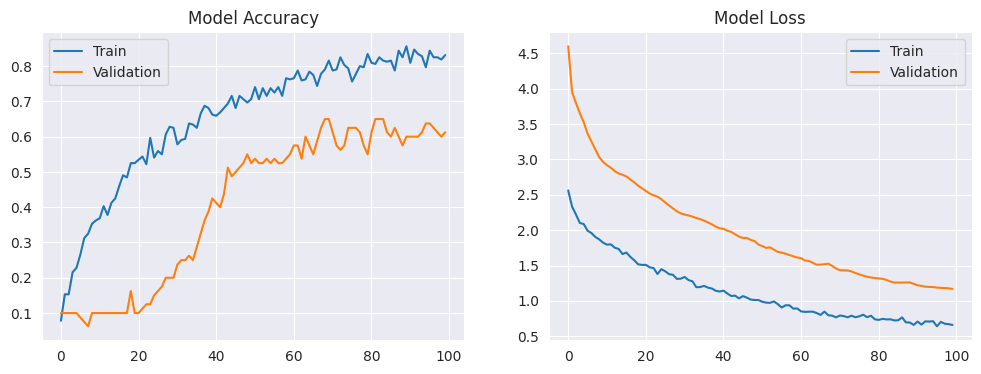

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


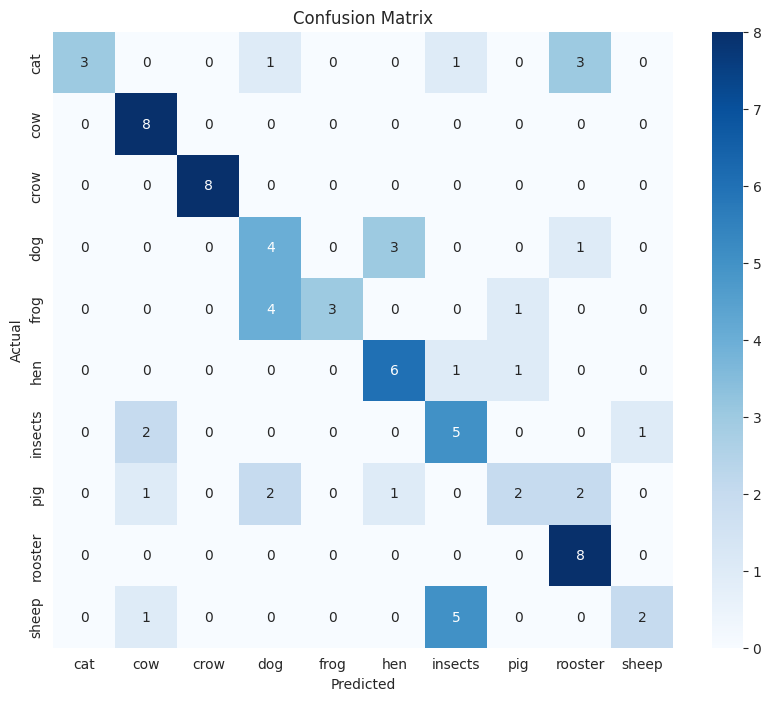

Classification Report:
              precision    recall  f1-score   support

         cat       1.00      0.38      0.55         8
         cow       0.67      1.00      0.80         8
        crow       1.00      1.00      1.00         8
         dog       0.36      0.50      0.42         8
        frog       1.00      0.38      0.55         8
         hen       0.60      0.75      0.67         8
     insects       0.42      0.62      0.50         8
         pig       0.50      0.25      0.33         8
     rooster       0.57      1.00      0.73         8
       sheep       0.67      0.25      0.36         8

    accuracy                           0.61        80
   macro avg       0.68      0.61      0.59        80
weighted avg       0.68      0.61      0.59        80



In [44]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

## 8. Model Evaluation

### Visualize Training History and Performance

Analyze model performance through:
1. **Accuracy Plot:** Track training vs validation accuracy over epochs
2. **Loss Plot:** Monitor training vs validation loss
3. **Confusion Matrix:** See which classes are confused with each other
4. **Classification Report:** Detailed per-class metrics (precision, recall, F1-score)

In [45]:
# Save the trained model
model_save_path = '/kaggle/working/animal_sound_model.h5'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Save label encoder classes for future inference
import pickle
encoder_path = '/kaggle/working/label_encoder.pkl'
with open(encoder_path, 'wb') as f:
    pickle.dump(le.classes_, f)
print(f"Label encoder saved to: {encoder_path}")

print("\nModel Summary:")
print(f"  Total classes: {len(le.classes_)}")
print(f"  Classes: {', '.join(le.classes_)}")
print(f"  Input shape: (128, {X_train.shape[2]}, 1)")
print(f"  Model size: ~{os.path.getsize(model_save_path) / (1024**2):.2f} MB")

Model saved to: /kaggle/working/animal_sound_model.h5
Label encoder saved to: /kaggle/working/label_encoder.pkl

Model Summary:
  Total classes: 10
  Classes: cat, cow, crow, dog, frog, hen, insects, pig, rooster, sheep
  Input shape: (128, 431, 1)
  Model size: ~1.34 MB


## 9. Save Trained Model

Save the trained model and label encoder for future use.

**Saved Files:**
- `animal_sound_model.h5` - Model in H5 format (legacy)
- `animal_sound_model.keras` - Model in Keras 3 native format (recommended)
- `label_encoder.pkl` - Class labels for inference

These files allow you to load and use the model without retraining.

In [49]:
# Load the saved model
from tensorflow.keras.models import load_model
from IPython.display import Audio, display

loaded_model = load_model('/kaggle/working/animal_sound_model.h5')
print("Model loaded successfully!")

# Load label encoder
with open('/kaggle/working/label_encoder.pkl', 'rb') as f:
    saved_classes = pickle.load(f)
print(f"Classes loaded: {saved_classes}")

Model loaded successfully!
Classes loaded: ['cat' 'cow' 'crow' 'dog' 'frog' 'hen' 'insects' 'pig' 'rooster' 'sheep']


## 10. Test Saved Model

### Load the Trained Model

Reload the saved model and label encoder to demonstrate inference on new audio samples.

Testing audio: 5-187201-B-4.wav
True label: FROG


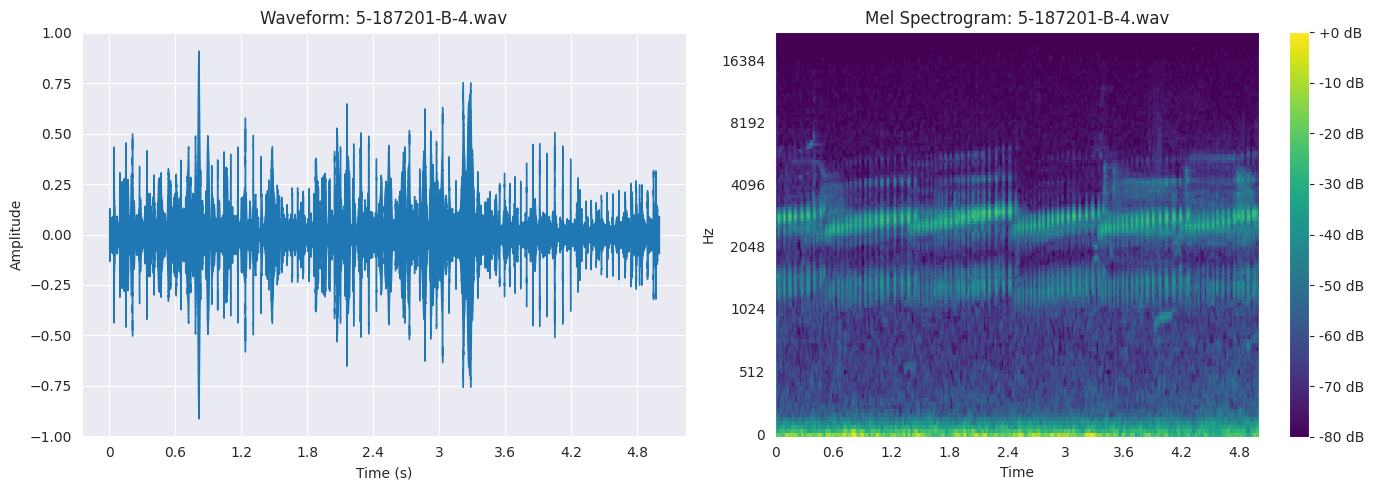


Play the audio:


In [60]:
# Select a random test audio file
test_sample = animal_df[animal_df['fold'] == 5].sample(1).iloc[0]
test_audio_path = os.path.join(AUDIO_DIR, test_sample['filename'])
true_label = test_sample['category']

print(f"Testing audio: {test_sample['filename']}")
print(f"True label: {true_label.upper()}")

# Load and preprocess the audio
audio, sr = librosa.load(test_audio_path, sr=None, duration=5.0)

# Visualize the test audio
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title(f'Waveform: {test_sample["filename"]}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram: {test_sample["filename"]}')

plt.tight_layout()
plt.show()

# Play the audio
print("\nPlay the audio:")
display(Audio(audio, rate=sr))

### Select and Visualize Test Samples

Select 3 random audio files from the test set (fold 5) and visualize them:
- Display waveforms and mel-spectrograms
- Provide audio playback
- Show true labels

This gives us a visual understanding of the test samples before making predictions.

In [61]:
# Extract features from test audio
mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
mels_db = librosa.power_to_db(mels, ref=np.max)

# Resize to match training shape (128x128)
target_width = 128
if mels_db.shape[1] < target_width:
    mels_db = np.pad(mels_db, ((0, 0), (0, target_width - mels_db.shape[1])))
else:
    mels_db = mels_db[:, :target_width]

# Reshape for model input
test_features = mels_db.reshape(1, 128, 128, 1)

print(f"Feature shape: {test_features.shape}")

# Make prediction
predictions = loaded_model.predict(test_features, verbose=0)
predicted_class_idx = np.argmax(predictions[0])
predicted_class = saved_classes[predicted_class_idx]
confidence = predictions[0][predicted_class_idx]

print("PREDICTION RESULTS")
print(f"\nTrue Label:      {true_label.upper()}")
print(f"Predicted Label: {predicted_class.upper()}")
print(f"Confidence:      {confidence*100:.2f}%")

if predicted_class == true_label:
    print("\nCORRECT PREDICTION!")
else:
    print("\nINCORRECT PREDICTION")


print("ALL CLASS PROBABILITIES")


# Sort predictions by probability
class_probs = [(saved_classes[i], predictions[0][i]) for i in range(len(saved_classes))]
class_probs.sort(key=lambda x: x[1], reverse=True)

for i, (cls, prob) in enumerate(class_probs, 1):
    bar_length = int(prob * 40)
    bar = '░' * bar_length + ' ' * (40 - bar_length)
    marker = "-" if cls == predicted_class else "  "
    print(f"{marker} {i:2d}. {cls:12s} {bar} {prob*100:5.2f}%")

print("="*70)

Feature shape: (1, 128, 128, 1)
PREDICTION RESULTS

True Label:      FROG
Predicted Label: FROG
Confidence:      62.58%

CORRECT PREDICTION!
ALL CLASS PROBABILITIES
-  1. frog         ░░░░░░░░░░░░░░░░░░░░░░░░░                62.58%
    2. cat          ░░░░░░░                                  17.55%
    3. hen          ░                                         4.80%
    4. sheep        ░                                         4.67%
    5. rooster      ░                                         3.15%
    6. dog                                                    1.86%
    7. crow                                                   1.82%
    8. insects                                                1.38%
    9. pig                                                    1.17%
   10. cow                                                    1.02%


### Make Predictions on Test Samples

For each of the 3 test samples:
1. Extract Mel-spectrogram features
2. Run model inference
3. Display predicted vs true labels
4. Show confidence scores
5. Display top 3 predictions with probability bars

This demonstrates real-world model performance on unseen data.

Testing audio: 5-214759-A-5.wav
True label: CAT


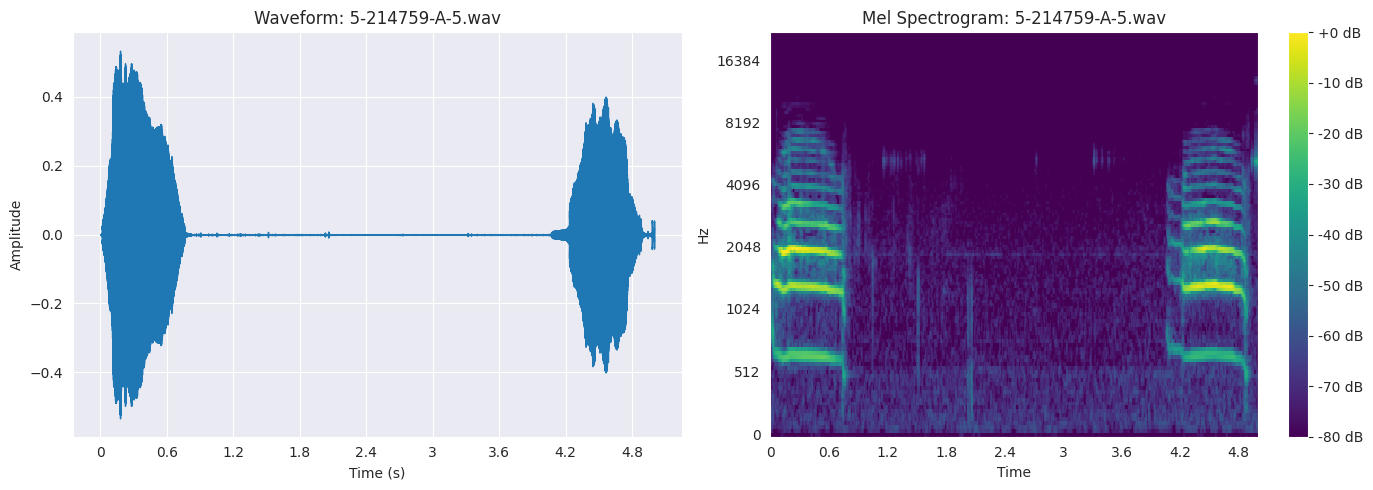


Play the audio:


In [65]:
# Select a random test audio file
test_sample = animal_df[animal_df['fold'] == 5].sample(1).iloc[0]
test_audio_path = os.path.join(AUDIO_DIR, test_sample['filename'])
true_label = test_sample['category']

print(f"Testing audio: {test_sample['filename']}")
print(f"True label: {true_label.upper()}")

# Load and preprocess the audio
audio, sr = librosa.load(test_audio_path, sr=None, duration=5.0)

# Visualize the test audio
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title(f'Waveform: {test_sample["filename"]}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram: {test_sample["filename"]}')

plt.tight_layout()
plt.show()

# Play the audio
print("\nPlay the audio:")
display(Audio(audio, rate=sr))

### Visualize All Predictions

Create a comprehensive visualization showing:
- Probability distributions for all 3 test samples
- Color-coded bars (green = predicted class, blue = other classes)
- True vs predicted labels with correct/incorrect indicators
- Side-by-side comparison of model confidence across all classes

This provides a clear visual summary of model performance on multiple samples.

In [66]:
# Extract features from test audio
mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
mels_db = librosa.power_to_db(mels, ref=np.max)

# Resize to match training shape (128x128)
target_width = 128
if mels_db.shape[1] < target_width:
    mels_db = np.pad(mels_db, ((0, 0), (0, target_width - mels_db.shape[1])))
else:
    mels_db = mels_db[:, :target_width]

# Reshape for model input
test_features = mels_db.reshape(1, 128, 128, 1)

print(f"Feature shape: {test_features.shape}")

# Make prediction
predictions = loaded_model.predict(test_features, verbose=0)
predicted_class_idx = np.argmax(predictions[0])
predicted_class = saved_classes[predicted_class_idx]
confidence = predictions[0][predicted_class_idx]

print("PREDICTION RESULTS")
print(f"\nTrue Label:      {true_label.upper()}")
print(f"Predicted Label: {predicted_class.upper()}")
print(f"Confidence:      {confidence*100:.2f}%")

if predicted_class == true_label:
    print("\nCORRECT PREDICTION!")
else:
    print("\nINCORRECT PREDICTION")


print("ALL CLASS PROBABILITIES")


# Sort predictions by probability
class_probs = [(saved_classes[i], predictions[0][i]) for i in range(len(saved_classes))]
class_probs.sort(key=lambda x: x[1], reverse=True)

for i, (cls, prob) in enumerate(class_probs, 1):
    bar_length = int(prob * 40)
    bar = '░' * bar_length + ' ' * (40 - bar_length)
    marker = "-" if cls == predicted_class else "  "
    print(f"{marker} {i:2d}. {cls:12s} {bar} {prob*100:5.2f}%")

print("="*70)

Feature shape: (1, 128, 128, 1)
PREDICTION RESULTS

True Label:      CAT
Predicted Label: CAT
Confidence:      68.49%

CORRECT PREDICTION!
ALL CLASS PROBABILITIES
-  1. cat          ░░░░░░░░░░░░░░░░░░░░░░░░░░░              68.49%
    2. rooster      ░░░░░░░░░░                               27.28%
    3. hen                                                    2.10%
    4. cow                                                    0.71%
    5. insects                                                0.38%
    6. pig                                                    0.35%
    7. crow                                                   0.24%
    8. dog                                                    0.19%
    9. sheep                                                  0.18%
   10. frog                                                   0.07%
